# Czech Republic

In [36]:
import io
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina'

## Fetch results

In [25]:
districts = ['7204', '7202', '5104', '5201', '6202', '3101', '6103', '6203', '6201', '5103', '2109', '2110', '3203', '6102', '5304', '3107', '5203', '5202', '6105', '5302', '6206', '6104', '5301', '6101', '3205', '5204', '3103', '3202', '2104', '7201', '3204', '2101', '5303', '2111', '3206', '7203', '5102', '3104', '5205', '7102', '2102', '2107', '4102', '3201', '2108', '3106', '2105', '7103', '6205', '2112', '7105', '8102', '4203', '3102', '6207', '6204', '8104', '7104', '2106', '8106', '3105', '4207', '8105', '2103', '5101', '7101', '4204', '4201', '3207', '8101', '4206', '4101', '8103', '4103', '4205', '4202', '1100']

In [19]:
def get_municipalities(url):
    base_url = 'https://www.volby.cz/pls/ep2019/'
    url = f'{base_url}/{url}'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    links = html.select('td.cislo > a')
    links = [x['href'] for x in links if x['href'].startswith('ep1311')]
    return links

In [37]:
def get_turnout(url):
    base_url = 'https://www.volby.cz/pls/ep2019'
    url = f'{base_url}/{url}'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    crumbs = get_crumbs(html)
    turnout = pd.read_html(io.StringIO(r.text), header=1)[0].iloc[0]['Volební účast v %']
    return (crumbs, turnout)

In [4]:
def get_crumbs(html):
    return html.select_one('p.drobek').text

In [26]:
%%time
municipalities = []

for district in districts:
    m = get_municipalities(f'ep133?XJAZYK=CZ&xnumnuts={district}')
    municipalities.extend(m)

CPU times: user 3.87 s, sys: 112 ms, total: 3.98 s
Wall time: 15.9 s


In [39]:
%%time
results = []

for mun in municipalities:
    turnout = get_turnout(mun)
    results.append(turnout)

CPU times: user 5min 9s, sys: 8.88 s, total: 5min 18s
Wall time: 45min 25s


In [40]:
df = pd.DataFrame(results, columns=['crumbs', 'turnout'])

In [43]:
df.turnout = df.turnout.astype(str).apply(lambda x: f'{x[:2]}.{x[2:]}').astype(float)

In [45]:
df = pd.concat([df, df.crumbs.str.split(' > ', expand=True)], axis=1)
df = df.drop(['crumbs', 0, 1, 2], axis=1)
df = df.rename(columns={3: 'district', 4: 'municipality'})
df.district = df.district.str.strip()
df.municipality = df.municipality.str.strip()
df['id'] = municipalities
df.id = df.id.str.extract('&xobec=(\d+)&')

In [47]:
df.to_csv('../../data/2019/raw/cze.csv', index=False)

In [48]:
df = pd.read_csv('../../data/2019/raw/cze.csv', dtype={'id': str})

## Merge

In [51]:
geo = gpd.read_file('../../data/2019/shapefiles/cze/OBCE_P.shp', encoding='cp1250')

In [52]:
geo = geo.to_crs(epsg=4326)

In [53]:
geo = geo.merge(df, left_on='KOD', right_on='id', how='left')

In [66]:
# Four of these are expected, non-constituency areas
geo[geo.turnout.isna()]

,KOD,NAZEV,POU_KOD,ORP_KOD,OKRES_KOD,LAU1_KOD,LAU2_KOD,NUTS3_KOD,VUSC_KOD,STATUS_KOD,...,SM_ROZ_KOD,SM_TYP_KOD,VLAJKA_TXT,ZNAK_TXT,ZKRATKA,geometry,turnout,district,municipality,id
20,503941,Libavá,3727,1899,3805,CZ0712,CZ0712 503941,CZ071,124,1,...,NaN,None,None,None,LIBAVA,"POLYGON ((17.61355 49.63500, 17.61344 49.63479...",NaN,NaN,NaN,NaN
1896,545422,Boletice,671,329,3302,CZ0312,CZ0312 545422,CZ031,35,1,...,NaN,None,"List tvoří dva svislé pruhy, bílý a zelený. V ...",Ve stříbrno-zeleně zvýšeně děleném štítě nahoř...,BOLETICE,"POLYGON ((14.17517 48.86914, 14.17477 48.86901...",NaN,NaN,NaN,NaN
2596,555177,Hradiště,1147,531,3403,CZ0412,CZ0412 555177,CZ041,51,1,...,NaN,None,"List tvoří dva vodorovné pruhy, zelený a žlutý...",V zeleném štítě nad zlatou palisádou zkřížené ...,HRADISTE,"POLYGON ((13.07992 50.34806, 13.07988 50.34818...",NaN,NaN,NaN,NaN
6155,592935,Březina,3301,1643,3712,CZ0646,CZ0646 592935,CZ064,116,1,...,NaN,None,"List tvoří tři svislé pruhy, bílý, zelený se š...",V zeleném štítě pod stříbrnou hlavou se šesti ...,BREZINA,"POLYGON ((16.85963 49.37703, 16.85977 49.37695...",NaN,NaN,NaN,NaN


In [64]:
# From website
geo.loc[lambda x: x.NAZEV == 'Praha', 'turnout'] = 38.31

## Export

In [73]:
geo = geo[['NAZEV', 'turnout', 'geometry']]
geo = geo.rename(columns={'NAZEV': 'name'})

In [74]:
geo['country'] = 'cze'

In [75]:
geo.to_file('../../data/2019/processed/cze', encoding='utf8')

## Visualize

/Users/robinlinderborg/dev/ep-election-turnout/.venv/lib/python3.9/site-packages/geopandas/plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


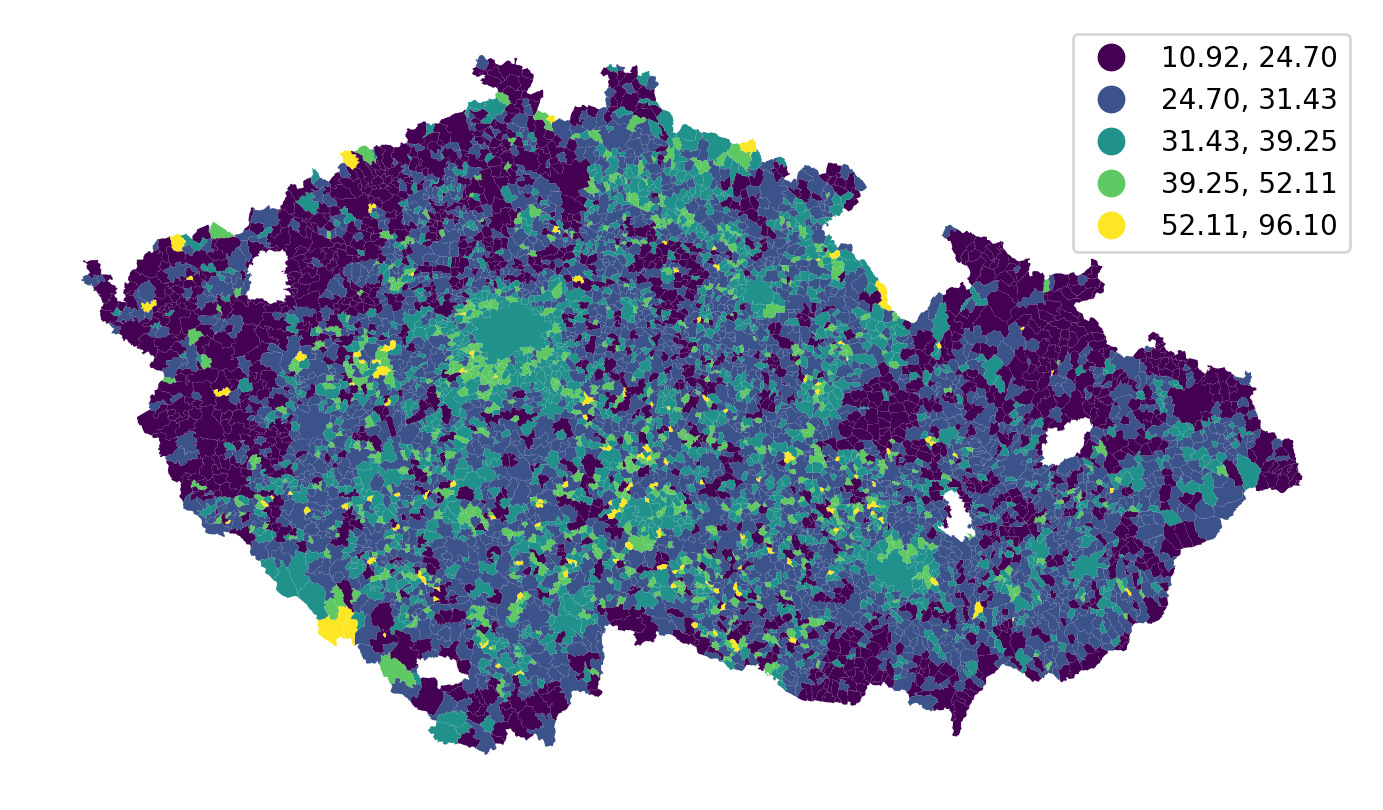

In [65]:
ax = geo.plot(figsize=(16, 5), column='turnout', legend=True, scheme='Fisher_Jenks');
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/cze_choropleth.png')